In [2]:
import os
import pandas as pd
import numpy as np
import pickle
from decimal import Decimal
import time
import argparse

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

# Prepare Data

In [401]:
parser = {
    'epochs': 3,
    'batch_size': 1,
    'lr': 0.001,
    'cuda': False,
    'seed': 7,
    'results': './results',
    'model_zoo': './model_zoo',
    'best_model': '/best_model.pth'
}

args = argparse.Namespace(**parser)
args.cuda = args.cuda and torch.cuda.is_available()
if not os.path.isdir(args.results):
    os.makedirs(args.results)
if not os.path.isdir(args.model_zoo):
    os.makedirs(args.model_zoo) 
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

## Read CSV

In [5]:
songs_1_2000 = pd.read_csv('./static_annotations_averaged_songs_1_2000.csv', sep='\s*,\s*', engine='python')

In [6]:
song_2000s = pd.read_csv('./static_annotations_averaged_songs_2000_2058.csv', sep='\s*,\s*', engine='python')

In [7]:
del songs_1_2000['valence_std']
del songs_1_2000['arousal_std']
for header in list(song_2000s.columns.values):
    if header != 'song_id' and header != 'valence_mean' and header != 'arousal_mean':
        del song_2000s[header]

In [8]:
df = songs_1_2000.append(song_2000s)

In [10]:
# Save our dataframe
#df_out = open("./df_songs", "wb")
#pickle.dump(df, df_out)

# Read data

In [887]:
df_out = open("./df_songs", "rb")
df = pickle.load(df_out)

In [341]:
def getValenceArousal(df, songId):
    valence = df.loc[df['song_id'] == songId]['valence_mean'].tolist()[0]
    arousal = df.loc[df['song_id'] == songId]['arousal_mean'].tolist()[0]
    target = (valence/10, arousal/10)
    return Variable(torch.Tensor(list(target)).view(-1, 2))

In [455]:
def getValence(df, songId):
    valence = df.loc[df['song_id'] == songId]['valence_mean'].tolist()[0]
    target = valence/10
    return Variable(torch.Tensor([target])).view(-1,1)

In [13]:
listSongs = os.listdir('./my_features/')

In [14]:
songId = df['song_id']

In [15]:
songId = songId.tolist()

In [16]:
def getLongterm(songId):
    f = open("./my_features/"+str(songId), "rb")
    longterm = pickle.load(f, encoding='latin1')
    longterm = list(map(roundUp, longterm))
    return longterm

In [17]:
def getShortTerm(songId):
    f = open("./my_features/"+str(songId), 'rb')
    shortterms = pickle.load(f, encoding='latin1')
    return shortterms

In [18]:
def roundUp(x):
    return round(float(Decimal(x)), 2)

# Get alll short term and scale it

In [553]:
from sklearn.preprocessing import MinMaxScaler

In [554]:
scaler = MinMaxScaler(feature_range=(0,1))

In [555]:
all_shortterms = []
for i in songId:
    all_shortterms += (getShortTerm(i))

In [556]:
scaler.fit(all_shortterms)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [863]:
import pickle

In [866]:
def save_scaler(scaler, fileName):
    f = open('./'+fileName, 'wb')
    pickle.dump(scaler, f, protocol=2)

In [867]:
save_scaler(scaler, "./model_zoo/scalerForShortTerms.sav")

# Model

In [825]:
class LSTMModel(nn.Module):
    
    def __init__(self, d_input, d_hidden_lstm, num_layer, d_output):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(d_input, d_hidden_lstm, num_layer)
        self.linear1 = nn.Linear(d_hidden_lstm*num_layer, d_output)
        self.d_hidden_lstm = d_hidden_lstm
        self.num_layer = num_layer

    def forward(self, x):
        h = Variable(torch.FloatTensor(self.num_layer, x.size(1),self.d_hidden_lstm).zero_(), requires_grad=False)
        c = Variable(torch.FloatTensor(self.num_layer, x.size(1), self.d_hidden_lstm).zero_(), requires_grad=False)
        _, (h_t, c_t) = self.lstm1(x, (h, c))
        #h_t = F.tanh(h_t.squeeze(0))
        h_t = F.tanh(h_t)
        out = self.linear1(h_t.view(-1, self.d_hidden_lstm*self.num_layer))
        return out
    

In [809]:
def train(epoch, model, listSongId, optimizer, criterion, start_time):
    train_loss = 0
    n_total = 0
    listSongId_val = listSongId[:int(len(listSongId)* 3/20)]
    listSongId_train = listSongId[int(len(listSongId)* 3/20):]
    for i in listSongId_train:
        model.train()
        shortterms = scaler.transform(getShortTerm(i))
        shorttermsVar = Variable(torch.FloatTensor(shortterms))
        shorttermsVar = shorttermsVar.view(shorttermsVar.size(0),1,33)
        target = getValenceArousal(df=df, songId=i)
        if args.cuda:
            shorttermsVar = shorttermsVar.cuda()
            target = target.cuda()
            
        output = model(shorttermsVar)
        
        loss = criterion(output, target)
        train_loss += loss.data[0]*10
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 3)
        optimizer.step()
        n_total += 1

    train_loss /= n_total
    valid_loss, valence_e_rate, arousal_e_rate = validate(model, listSongId_val, criterion)
    
    print("=> EPOCH {}|Time: {:3.0f}s | Song Id: {:5} | Train loss: {:.4f} | Val loss: {:.4f}"
          "| Valence: {:.4f} | Arousal: {:.4f}"
                  .format(epoch, time.time()-start_time, i, train_loss, valid_loss, valence_e_rate, arousal_e_rate))
    return valid_loss

In [810]:
def validate(model, listSongId_val, criterion):
    model.eval()
    valid_loss = 0
    valence_rate = 0
    arousal_rate = 0
    
    n_total = len(listSongId_val)
    for i in listSongId_val:
        shortterms = scaler.transform(getShortTerm(i))
        shorttermsVar = Variable(torch.FloatTensor(shortterms))
        shorttermsVar = shorttermsVar.view(shorttermsVar.size(0),1,33)
        target = getValenceArousal(df=df, songId=i)
        if args.cuda:
            shorttermsVar = shorttermsVar.cuda()
            target = target.cuda()
            
        output = model(shorttermsVar)
        loss = criterion(output, target)
        valid_loss += loss.data[0]*10
        valence_error_rate = abs(output.data[0,0]-target.data[0,0])/target.data[0,0]
        arousal_error_rate = abs(output.data[0,1]-target.data[0,1])/target.data[0,1]
        valence_rate += valence_error_rate
        arousal_rate += arousal_error_rate
    valid_loss /= n_total
    valence_rate /= n_total
    arousal_rate /= n_total
    return (valid_loss, valence_rate, arousal_rate)

In [826]:
model = LSTMModel(33, 50, 2, 2)
criterion = nn.MSELoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
if args.cuda:
    model = model.cuda()
    criterion = criterion.cuda()
    optimizer = optimizer.cuda()

In [827]:
model.parameters

<bound method Module.parameters of LSTMModel (
  (lstm1): LSTM(33, 50, num_layers=2)
  (linear1): Linear (100 -> 2)
)>

In [835]:
best_valid_loss = 100
for epoch in range(0, 20):
    start_time = time.time()
    #train_test(epoch, model, listSongId=songId, optimizer=optimizer, criterion=criterion)
    valid_loss = train(epoch, model, listSongId=songId, optimizer=optimizer, criterion=criterion, start_time=start_time)
    #if valid_loss < best_valid_loss:
    #    best_valid_loss = valid_loss
    #    torch.save(model.state_dict(), args.model_zoo + args.best_model)

=> EPOCH 0|Time: 107s | Song Id:  2058 | Train loss: 0.0924 | Val loss: 0.1368| Valence: 0.2378 | Arousal: 0.2415
=> EPOCH 1|Time: 107s | Song Id:  2058 | Train loss: 0.0914 | Val loss: 0.1365| Valence: 0.2362 | Arousal: 0.2416
=> EPOCH 2|Time: 107s | Song Id:  2058 | Train loss: 0.0905 | Val loss: 0.1363| Valence: 0.2346 | Arousal: 0.2419
=> EPOCH 3|Time: 107s | Song Id:  2058 | Train loss: 0.0896 | Val loss: 0.1362| Valence: 0.2331 | Arousal: 0.2422
=> EPOCH 4|Time: 106s | Song Id:  2058 | Train loss: 0.0888 | Val loss: 0.1361| Valence: 0.2316 | Arousal: 0.2427
=> EPOCH 5|Time: 108s | Song Id:  2058 | Train loss: 0.0881 | Val loss: 0.1361| Valence: 0.2302 | Arousal: 0.2432
=> EPOCH 6|Time: 108s | Song Id:  2058 | Train loss: 0.0873 | Val loss: 0.1362| Valence: 0.2288 | Arousal: 0.2436
=> EPOCH 7|Time: 107s | Song Id:  2058 | Train loss: 0.0867 | Val loss: 0.1363| Valence: 0.2274 | Arousal: 0.2441
=> EPOCH 8|Time: 107s | Song Id:  2058 | Train loss: 0.0860 | Val loss: 0.1364| Valence:

=> EPOCH 0|Time: 104s | Song Id:  2058 | Train loss: 0.1326 | Val loss: 0.1504| Valence: 0.2673 | Arousal: 0.2515
=> EPOCH 1|Time: 105s | Song Id:  2058 | Train loss: 0.1052 | Val loss: 0.1467| Valence: 0.2604 | Arousal: 0.2491
=> EPOCH 2|Time: 106s | Song Id:  2058 | Train loss: 0.1029 | Val loss: 0.1442| Valence: 0.2558 | Arousal: 0.2466
=> EPOCH 3|Time: 106s | Song Id:  2058 | Train loss: 0.1011 | Val loss: 0.1424| Valence: 0.2522 | Arousal: 0.2448
=> EPOCH 4|Time: 105s | Song Id:  2058 | Train loss: 0.0995 | Val loss: 0.1410| Valence: 0.2494 | Arousal: 0.2436
=> EPOCH 5|Time: 105s | Song Id:  2058 | Train loss: 0.0981 | Val loss: 0.1399| Valence: 0.2470 | Arousal: 0.2427
=> EPOCH 6|Time: 107s | Song Id:  2058 | Train loss: 0.0968 | Val loss: 0.1390| Valence: 0.2449 | Arousal: 0.2421
=> EPOCH 7|Time: 107s | Song Id:  2058 | Train loss: 0.0956 | Val loss: 0.1382| Valence: 0.2429 | Arousal: 0.2416
=> EPOCH 8|Time: 109s | Song Id:  2058 | Train loss: 0.0945 | Val loss: 0.1377| Valence: 0.2412 | Arousal: 0.2414
=> EPOCH 9|Time: 111s | Song Id:  2058 | Train loss: 0.0934 | Val loss: 0.1372| Valence: 0.2394 | Arousal: 0.2414


In [841]:
train_losses = [0.1326, 0.1052, 0.1029, 0.1011, 0.0995, 0.0981, 0.0968, 
 0.0956, 0.0945, 0.0934, 0.0924, 0.0914, 0.0905, 0.0896, 
 0.0888, 0.0881, 0.0873, 0.0867, 0.0860, 0.0854, 0.0849,
 0.0844, 0.0839, 0.0835, 0.0831, 0.0828, 0.0825, 0.0822,
 0.0819, 0.0817]
val_losses = [0.1504, 0.1467, 0.1442, 0.1424, 0.1410, 0.1399, 0.1390,
              0.1382, 0.1377, 0.1372, 0.1368, 0.1365, 0.1363, 0.1362,
              0.1361, 0.1361, 0.1362, 0.1363, 0.1364, 0.1366, 0.1368,
              0.1371, 0.1373, 0.1376, 0.1379, 0.1382, 0.1385, 0.1388, 
              0.1391, 0.1394]

In [842]:
import matplotlib.pyplot as plt
%matplotlib inline

In [850]:
from pylab import rcParams
rcParams['figure.figsize'] = 30, 20
rcParams['xtick.labelsize'] = 22
rcParams['ytick.labelsize'] = 22

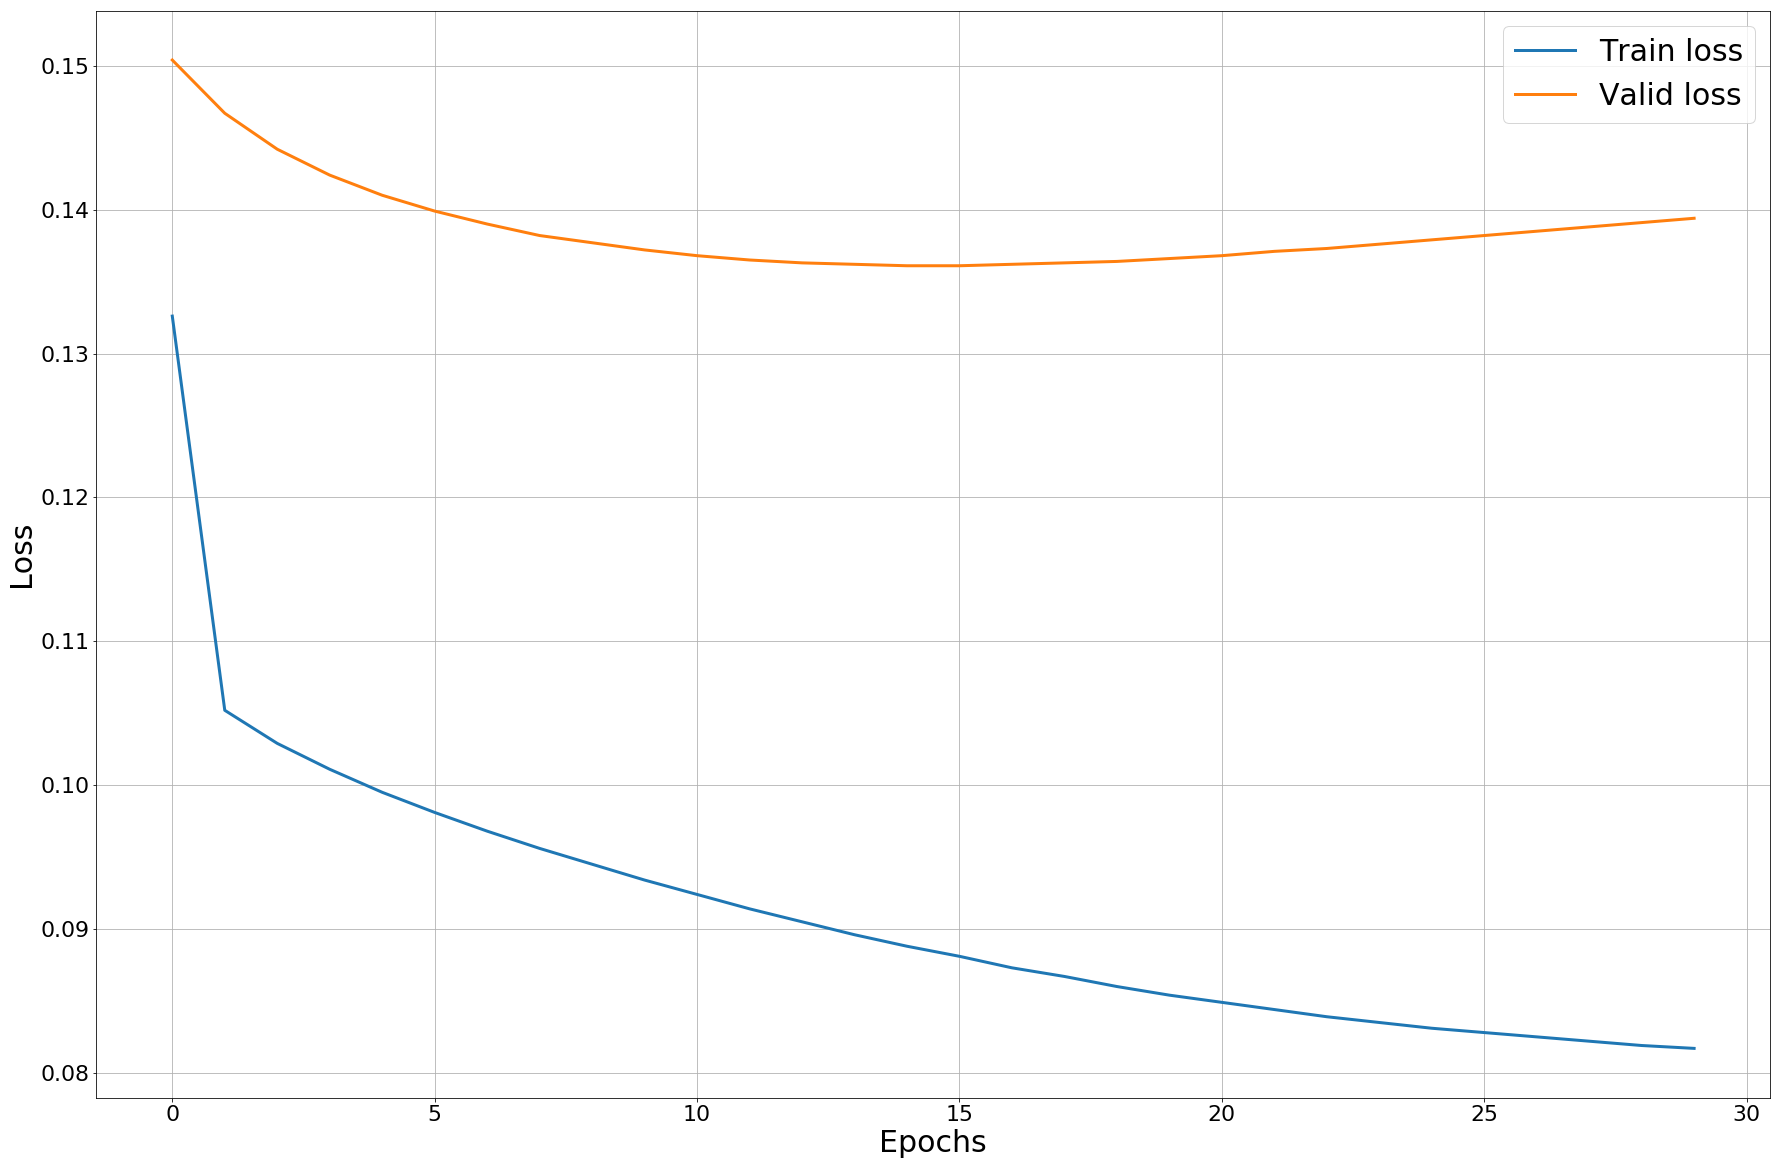

In [856]:
plt.plot(train_losses, linewidth=3, label="Train loss")
plt.plot(val_losses, linewidth=3, label="Valid loss")
plt.grid()
plt.legend(fontsize=30)
plt.xlabel("Epochs", fontsize=30)
plt.ylabel("Loss", fontsize=30)
plt.show()

In [860]:
shortterms = scaler.transform(getShortTerm(12))
#shortterms = getShortTerm(12)
shorttermsVar = Variable(torch.FloatTensor(shortterms))
shorttermsVar = shorttermsVar.view(shorttermsVar.size(0),1,33)

In [861]:
out1= model(shorttermsVar)

In [875]:
out1.data[0,1]*10

5.179820656776428

In [859]:
out1.t()

Variable containing:
 0.7113
 0.3815
[torch.FloatTensor of size 2x1]

In [801]:
list(model.lstm1.parameters())[:2]

[Parameter containing:
  4.4036e-02  1.7066e-01  3.9493e-02  ...   8.9807e-02  1.9173e-02  8.5699e-02
  3.4440e-02  3.3277e-02  1.2085e-01  ...  -7.9660e-02  8.3330e-02 -1.1702e-01
 -1.0108e-01  3.3738e-02 -4.2567e-02  ...  -1.9556e-01 -1.5576e-01 -1.9866e-01
                 ...                   ⋱                   ...                
 -7.5637e-02 -1.4580e-02  3.3025e-02  ...   7.5864e-02  1.8499e-01 -3.9865e-02
  1.1696e-01  4.5942e-02  1.0562e-01  ...   1.6747e-01 -9.2520e-02  1.5085e-01
  1.1638e-01 -1.1257e-01  1.5411e-01  ...   7.2195e-02 -1.6673e-01  4.4452e-03
 [torch.FloatTensor of size 120x33], Parameter containing:
 -1.3485e-01 -1.4152e-01 -1.5621e-01  ...   1.6920e-01 -9.7852e-02 -1.0219e-01
 -1.0319e-01  8.9539e-02  1.3251e-01  ...  -2.0327e-01 -1.0612e-01  1.4252e-01
  7.7742e-02  1.2853e-01  1.1811e-02  ...   1.6655e-01  3.9671e-02  1.0364e-01
                 ...                   ⋱                   ...                
 -1.9411e-01 -7.3102e-02  1.1108e-01  ...  -2.033

In [899]:
torch.save(model.state_dict(), args.model_zoo + args.best_model)

In [888]:
target = getValenceArousal(df=df, songId=2)

In [873]:
target

Variable containing:
 0.5500  0.5800
[torch.FloatTensor of size 1x2]

In [675]:
loss = criterion(out1, target)
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [676]:
print(loss)

Variable containing:
nan
[torch.FloatTensor of size 1]



In [637]:
model(shorttermsVar)

Variable containing:
1.00000e-02 *
 -0.2639 -1.3220
[torch.FloatTensor of size 1x2]

In [638]:
target

Variable containing:
 0.3400  0.2800
[torch.FloatTensor of size 1x2]

In [639]:
target.data[0,1]

0.2800000011920929

# LOAD model

In [900]:
model_load = LSTMModel(33, 50, 2, 2)    
model_load.load_state_dict(torch.load("./model_zoo/best_model.pth"))


In [901]:
aDict = {"valence_mean_predicted": [], "arousal_mean_predicted": []}
for i in songId:
    shortterms = scaler.transform(getShortTerm(i))
    shorttermsVar = Variable(torch.FloatTensor(shortterms))
    shorttermsVar = shorttermsVar.view(shorttermsVar.size(0),1,33)
    output = model_load(shorttermsVar)
    valence, arousal = output.data[0,0]*10, output.data[0,1]*10
    aDict["valence_mean_predicted"].append(valence)
    aDict["arousal_mean_predicted"].append(arousal)

In [902]:
aDict["songId"]= songId

In [903]:
df_predicted = pd.DataFrame.from_dict(aDict)

In [904]:
df_predicted.head(20)

,arousal_mean_predicted,songId,valence_mean_predicted
0,5.339479,2,5.047684
1,4.500100,3,4.565485
2,5.502889,4,5.452212
3,4.075323,5,4.306961
4,5.323739,7,5.291112
5,4.986744,8,4.991042
6,4.778561,10,4.969724
7,5.179821,12,5.517093
8,3.996446,13,4.478602
9,5.372656,17,5.471354


In [905]:
col = df_predicted.columns.tolist()

In [906]:
col = ['songId', 'valence_mean_predicted', 'arousal_mean_predicted']

In [907]:
df_predicted = df_predicted[col]

In [908]:
df_predicted.to_csv("./dfVALSTMPredictionBestTrainLoss.csv")

In [911]:
getValenceArousal(df,35)

Variable containing:
 0.4800  0.6500
[torch.FloatTensor of size 1x2]